## 0. data reading

In [16]:
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt

In [17]:
model_list = [
                "facebook/opt-1.3b",
                "meta-llama/Meta-Llama-3-8B",
                "mistralai/Mistral-7B-v0.1",
                ]

In [18]:
for model_name1 in model_list:
    base_path = './'
    data_name = 'triviaqa'

    save_result_path = "{}/result/{}/{}".format(base_path, data_name, model_name1)
    os.makedirs(save_result_path, exist_ok=True) 
    save_file_name = f"{save_result_path}/log_likelihood_list_correct.pt"

    with open(save_file_name, 'rb') as f:
        log_likelihood_list1 = pickle.load(f)
    log_likelihood_list1 = np.array(log_likelihood_list1)
    print(model_name1, np.mean(log_likelihood_list1))

facebook/opt-1.3b -12.357440952195484
meta-llama/Meta-Llama-3-8B -5.257429582691421
mistralai/Mistral-7B-v0.1 -5.4396624359856505


In [19]:
base_path = './'

data_name = 'triviaqa'
model_name1 = "meta-llama/Meta-Llama-3-8B"

save_result_path = "{}/result/{}/{}".format(base_path, data_name, model_name1)
os.makedirs(save_result_path, exist_ok=True) 
save_file_name = f"{save_result_path}/log_likelihood_list_correct.pt"
with open(save_file_name, 'rb') as f:
    log_likelihood_list1 = pickle.load(f)
log_likelihood_list1 = np.array(log_likelihood_list1)


In [20]:
base_path = './'

data_name = 'triviaqa'
model_name2 = "mistralai/Mistral-7B-v0.1"

save_result_path = "{}/result/{}/{}".format(base_path, data_name, model_name2)
os.makedirs(save_result_path, exist_ok=True) 
save_file_name = f"{save_result_path}/log_likelihood_list_correct.pt"
with open(save_file_name, 'rb') as f:
    log_likelihood_list2 = pickle.load(f)
log_likelihood_list2 = np.array(log_likelihood_list2)

In [21]:
base_path = './'

data_name = 'triviaqa'
model_name3 = "facebook/opt-1.3b"

save_result_path = "{}/result/{}/{}".format(base_path, data_name, model_name3)
os.makedirs(save_result_path, exist_ok=True)
save_file_name = f"{save_result_path}/log_likelihood_list_correct.pt"
with open(save_file_name, 'rb') as f:
    log_likelihood_list3 = pickle.load(f)
log_likelihood_list3 = np.array(log_likelihood_list3)

## 1. prepare

In [22]:
import numpy as np
from scipy.stats import norm
from scipy.optimize import root
import warnings

class ShortestIntervalCalculator:
    def __init__(self, grid_points=8000, grid_range=(-8, 8)):

        self.grid_points = grid_points
        self.grid_range = grid_range
        
    def edgeworth_cdf(self, x, n, kappa3, kappa4):
        x = np.asarray(x, dtype=float)
        Phi = norm.cdf(x)
        phi = norm.pdf(x)

        if n <= 0:
            return Phi
        term1 = (n**-0.5) * (kappa3 / 6.0) * (2*x**2 + 1) * phi
        term2 = (n**-1.0) * ((kappa4 / 12.0) * x * (x**2 - 3) -
                            (kappa3**2 / 18.0) * x * (x**4 + 2*x**2 - 3) - 1 / 4.0 * x * (x**2 + 3)) * phi
        Fn = Phi + term1 + term2
        return np.clip(Fn, 1e-12, 1-1e-12)
    
    
    def edgeworth_pdf(self, x, n, kappa3, kappa4):
        h = 1e-6
        cdf_upper = self.edgeworth_cdf(x + h, n, kappa3, kappa4)
        cdf_lower = self.edgeworth_cdf(x - h, n, kappa3, kappa4)
        return (cdf_upper - cdf_lower) / (2 * h)
    
    def equal_tailed_interval(self, alpha, n, kappa3, kappa4):

        p_lower = alpha / 2
        p_upper = 1 - alpha / 2
        
        def find_quantile(p):
            def objective(x):
                return self.edgeworth_cdf(x, n, kappa3, kappa4) - p

            x_left, x_right = -10, 10
            while objective(x_left) > 0:
                x_left -= 5
            while objective(x_right) < 0:
                x_right += 5
                
            for _ in range(50): 
                x_mid = (x_left + x_right) / 2
                if abs(objective(x_mid)) < 1e-10:
                    break
                if objective(x_mid) > 0:
                    x_right = x_mid
                else:
                    x_left = x_mid
            return x_mid
        
        try:
            lower = find_quantile(p_lower)
            upper = find_quantile(p_upper)
            return lower, upper, {'method': 'equal_tailed', 'success': True}
        except:
            return norm.ppf(p_lower), norm.ppf(p_upper), {'method': 'normal_fallback', 'success': False}
    
    def grid_search_interval(self, alpha, n, kappa3, kappa4):
        try:
            x_grid = np.linspace(self.grid_range[0], self.grid_range[1], self.grid_points)
            cdf_values = self.edgeworth_cdf(x_grid, n, kappa3, kappa4)

            dF = np.diff(cdf_values)
            is_monotonic = np.all(dF >= -1e-10)
            non_monotonic_points = np.sum(dF < -1e-10)
            
            confidence_level = 1 - alpha
            best_interval = None
            min_length = float('inf')
            
            step = max(1, self.grid_points // 1000) 
            n_grid = len(x_grid)
            
            for i in range(0, n_grid, step):
                target_cdf = cdf_values[i] + confidence_level
                j_candidates = np.where(cdf_values[i:] >= target_cdf)[0]
                
                if len(j_candidates) > 0:
                    j = i + j_candidates[0]
                    if j < n_grid:
                        actual_coverage = cdf_values[j] - cdf_values[i]
                        if actual_coverage >= confidence_level:
                            length = x_grid[j] - x_grid[i]
                            if length < min_length:
                                min_length = length
                                best_interval = (x_grid[i], x_grid[j])
            
            if best_interval is not None:
                return best_interval[0], best_interval[1], {
                    'method': 'grid_search',
                    'success': True,
                    'is_monotonic': is_monotonic,
                    'non_monotonic_points': non_monotonic_points,
                    'interval_length': min_length
                }
            else:
                raise ValueError(
                    "No interval that meets the conditions was found")
                
        except Exception as e:
            return self.equal_tailed_interval(alpha, n, kappa3, kappa4)
    
    def hdi_optimization_interval(self, alpha, n, kappa3, kappa4, initial_guess=None):
        if initial_guess is None:
            initial_guess = [norm.ppf(alpha/2), norm.ppf(1-alpha/2)]
        
        def equations(vars):
            L, U = vars
            if L >= U:
                return [1e6, 1e6]  
            
            try:
                eq1 = self.edgeworth_cdf(U, n, kappa3, kappa4) - \
                      self.edgeworth_cdf(L, n, kappa3, kappa4) - (1 - alpha)
                
                eq2 = self.edgeworth_pdf(L, n, kappa3, kappa4) - \
                      self.edgeworth_pdf(U, n, kappa3, kappa4)
                
                return [eq1, eq2]
            except:
                return [1e6, 1e6]
        
        try:
            methods = ['hybr', 'lm', 'broyden1']
            
            for method in methods:
                try:
                    sol = root(equations, initial_guess, method=method)
                    if sol.success and sol.x[0] < sol.x[1]:
                        lower, upper = sol.x
                        return lower, upper, {
                            'method': f'hdi_{method}',
                            'success': True,
                            'interval_length': upper - lower,
                            'optimization_message': sol.message
                        }
                except:
                    continue
            
            raise ValueError("All the optimization methods failed")
            
        except Exception as e:

            return self.equal_tailed_interval(alpha, n, kappa3, kappa4)
    
    def calculate_shortest_interval(self, alpha, n, kappa3, kappa4, method='adaptive'):
        if not (0 < alpha < 1):
            raise ValueError("alpha must be between (0,1)")
        if n <= 0:
            raise ValueError("Sample size n must be positive")
        if not (np.isfinite(kappa3) and np.isfinite(kappa4)):
            return norm.ppf(alpha/2), norm.ppf(1-alpha/2), {'method': 'normal_fallback'}
        
        if method == 'equal_tailed':
            return self.equal_tailed_interval(alpha, n, kappa3, kappa4)
        
        elif method == 'grid_search':
            return self.grid_search_interval(alpha, n, kappa3, kappa4)
        
        elif method == 'hdi_optimization':
            return self.hdi_optimization_interval(alpha, n, kappa3, kappa4)
        
        elif method == 'adaptive':
            if abs(kappa3) < 0.2 and abs(kappa4) < 0.3:
                return self.equal_tailed_interval(alpha, n, kappa3, kappa4)
            
            elif abs(kappa3) < 1.0 and abs(kappa4) < 1.5:
                lower_hdi, upper_hdi, info_hdi = self.hdi_optimization_interval(alpha, n, kappa3, kappa4)
                if info_hdi['success']:
                    return lower_hdi, upper_hdi, info_hdi
                else:
                    return self.grid_search_interval(alpha, n, kappa3, kappa4)
            else:
                lower_grid, upper_grid, info_grid = self.grid_search_interval(alpha, n, kappa3, kappa4)
                if info_grid['success']:
                    return lower_grid, upper_grid, info_grid
                else:
                    return self.equal_tailed_interval(alpha, n, kappa3, kappa4)
        else:
            raise ValueError(f"Unknown method: {method}")


shortest_interval_calc = ShortestIntervalCalculator()

def calculate_shortest_confidence_interval(alpha, n, kappa3, kappa4, method='adaptive'):
    return shortest_interval_calc.calculate_shortest_interval(alpha, n, kappa3, kappa4, method)

In [23]:
import matplotlib.pyplot as plt

plt.rcParams.update({
    "font.size": 14,          
    "axes.titlesize": 16,     
    "axes.labelsize": 16,     
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.fontsize": 14,
})

## 2. computations and visualizations

### meta_minus_fb

In [ ]:
from scipy.stats import moment
import random
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
N = len(log_likelihood_list1) 

alpha = 0.10
z = norm.ppf(1 - alpha/2)

meta_minus_fb = np.array([meta - fb
                         for fb, meta in zip(log_likelihood_list3, log_likelihood_list1)])

L_ees = []
U_ees = []
L_clt, U_clt = [], []
num_list = [5,10,20,30,40,50,100,300,500,800,1000,2000,5000,10000,N]

for n in num_list:
    l_ees,u_ees,l_clt,u_clt = [],[],[],[]
    data = random.choices(meta_minus_fb, k=n)
    mean = np.mean(data)
    std = np.std(data)
    k3 = moment(data, moment=3) / (std ** 3)
    k4 = moment(data, moment=4) / (std ** 4) - 3

    q_lo, q_hi, _ = calculate_shortest_confidence_interval(alpha, n, k3, k4, method='hdi_optimization')
    lower_ees = mean - std/np.sqrt(n) * q_hi
    upper_ees = mean - std/np.sqrt(n) * q_lo
    lower_clt = mean - z * std/np.sqrt(n)
    upper_clt = mean + z * std/np.sqrt(n)
    L_ees.append(lower_ees)
    U_ees.append(upper_ees)
    L_clt.append(lower_clt)
    U_clt.append(upper_clt)

L_ees = np.array(L_ees)
U_ees = np.array(U_ees)
L_clt = np.array(L_clt)
U_clt = np.array(U_clt)

ees_mid = (L_ees + U_ees) / 2
ees_err = (U_ees - L_ees) / 2
clt_mid = (L_clt + U_clt) / 2
clt_err = (U_clt - L_clt) / 2

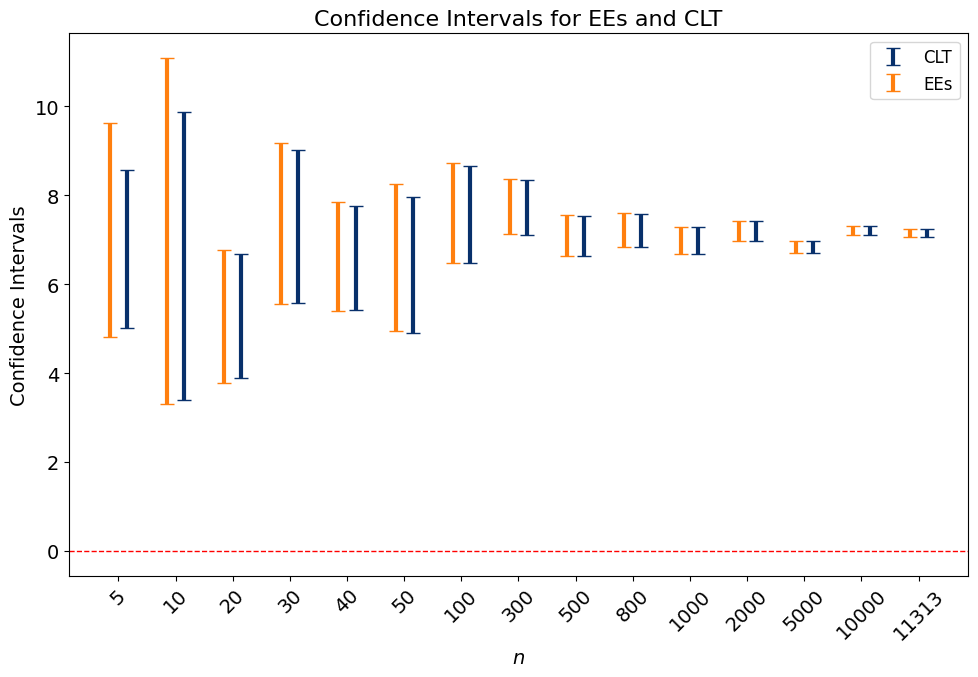

In [25]:
x_coords = range(len(num_list))
fig, ax = plt.subplots(figsize=(10, 7))

x_coords = np.array(range(len(num_list)))

ax.errorbar(x_coords + 0.15, clt_mid, yerr=clt_err, fmt='none',
            capsize=5, color='#08306b', elinewidth=3, label='CLT')
ax.errorbar(x_coords - 0.15, ees_mid, yerr=ees_err, fmt='none',
            capsize=5, color='#ff7f0e', elinewidth=3, label='EEs')

tick_labels_to_show = num_list

ax.set_xticks(x_coords)
ax.set_xticklabels(tick_labels_to_show, rotation=45)
ax.set_xlabel(r'$n$', fontsize=14)
ax.set_ylabel('Confidence Intervals', fontsize=14)
ax.set_title('Confidence Intervals for EEs and CLT', fontsize=16)
ax.legend(fontsize=12)
ax.axhline(0, color='red', linestyle='--', linewidth=1)


plt.tight_layout()
plt.savefig("meta_fb.png", dpi=500)
plt.show()

### mis_minus_meta

In [ ]:
from scipy.stats import moment
import random
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
N = len(log_likelihood_list1)

alpha = 0.10
z = norm.ppf(1 - alpha/2)

mis_minus_meta = np.array([mis - meta
                          for mis, meta in zip(log_likelihood_list2, log_likelihood_list1)])

L_ees = []
U_ees = []
L_clt, U_clt = [], []
num_list = [5, 10, 20, 30, 40, 50, 100, 300,
            500, 800, 1000, 2000, 5000, 10000, N]

for n in num_list:
    l_ees, u_ees, l_clt, u_clt = [], [], [], []
    data = random.choices(mis_minus_meta, k=n)
    mean = np.mean(data)
    std = np.std(data)
    k3 = moment(data, moment=3) / (std ** 3)
    k4 = moment(data, moment=4) / (std ** 4) - 3

    q_lo, q_hi, _ = calculate_shortest_confidence_interval(
        alpha, n, k3, k4, method='hdi_optimization')
    lower_ees = mean - std/np.sqrt(n) * q_hi
    upper_ees = mean - std/np.sqrt(n) * q_lo
    lower_clt = mean - z * std/np.sqrt(n)
    upper_clt = mean + z * std/np.sqrt(n)
    L_ees.append(lower_ees)
    U_ees.append(upper_ees)
    L_clt.append(lower_clt)
    U_clt.append(upper_clt)

L_ees = np.array(L_ees)
U_ees = np.array(U_ees)
L_clt = np.array(L_clt)
U_clt = np.array(U_clt)

ees_mid = (L_ees + U_ees) / 2
ees_err = (U_ees - L_ees) / 2
clt_mid = (L_clt + U_clt) / 2
clt_err = (U_clt - L_clt) / 2

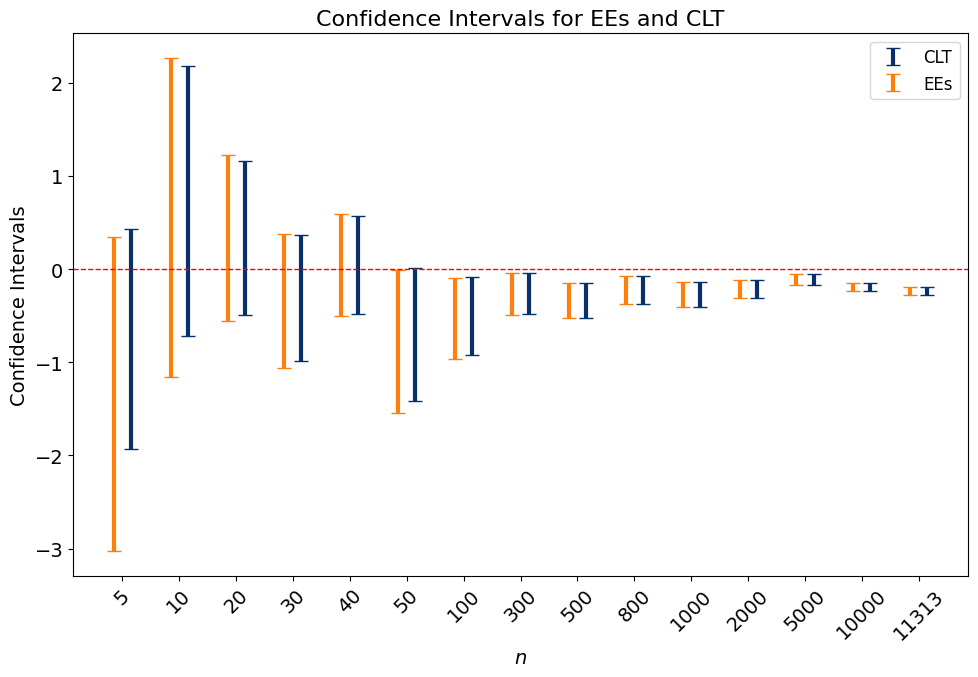

In [27]:
x_coords = range(len(num_list))
fig, ax = plt.subplots(figsize=(10, 7))  

x_coords = np.array(range(len(num_list))) 

ax.errorbar(x_coords + 0.15, clt_mid, yerr=clt_err, fmt='none',
            capsize=5, color='#08306b', elinewidth=3, label='CLT')
ax.errorbar(x_coords - 0.15, ees_mid, yerr=ees_err, fmt='none',
            capsize=5, color='#ff7f0e', elinewidth=3, label='EEs')

tick_labels_to_show = num_list

ax.set_xticks(x_coords)
ax.set_xticklabels(tick_labels_to_show, rotation=45)  
ax.set_xlabel(r'$n$', fontsize=14)
ax.set_ylabel('Confidence Intervals', fontsize=14)
ax.set_title('Confidence Intervals for EEs and CLT', fontsize=16)
ax.legend(fontsize=12)
ax.axhline(0, color='red', linestyle='--', linewidth=1)


plt.tight_layout()
plt.savefig("meta_mis.png", dpi=500)
plt.show()

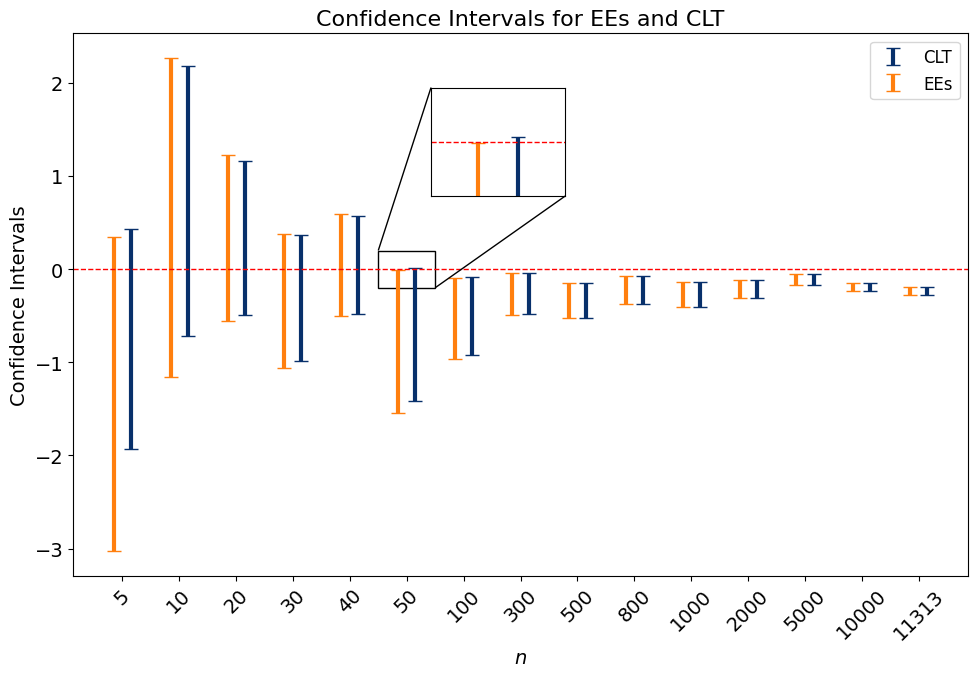

In [28]:
x_coords = range(len(num_list))
fig, ax = plt.subplots(figsize=(10, 7)) 

x_coords = np.array(range(len(num_list)))  
ax.errorbar(x_coords + 0.15, clt_mid, yerr=clt_err, fmt='none',
            capsize=5, color='#08306b', elinewidth=3, label='CLT')
ax.errorbar(x_coords - 0.15, ees_mid, yerr=ees_err, fmt='none',
            capsize=5, color='#ff7f0e', elinewidth=3, label='EEs')

tick_labels_to_show = num_list
ax.set_xticks(x_coords)
ax.set_xticklabels(tick_labels_to_show, rotation=45) 

ax.set_xlabel(r'$n$', fontsize=14)
ax.set_ylabel('Confidence Intervals', fontsize=14)
ax.set_title('Confidence Intervals for EEs and CLT', fontsize=16)
ax.legend(fontsize=12)
ax.axhline(0, color='red', linestyle='--', linewidth=1)

try:
    n_50_index = num_list.index(50)
except ValueError:
    n_50_index = -1

if n_50_index != -1:
    ax_inset = ax.inset_axes([0.4, 0.7, 0.15, 0.2])
    ax_inset.errorbar(x_coords + 0.15, clt_mid, yerr=clt_err, fmt='none',
                      capsize=5, color='#08306b', elinewidth=3)
    ax_inset.errorbar(x_coords - 0.15, ees_mid, yerr=ees_err, fmt='none',
                      capsize=5, color='#ff7f0e', elinewidth=3)

    ax_inset.set_xlim(n_50_index - 0.5, n_50_index + 0.5)
    ax_inset.set_ylim(-0.2, 0.2)  
    ax_inset.axhline(0, color='red', linestyle='--', linewidth=1)
    ax_inset.set_xticks([])
    ax_inset.set_yticks([])
    ax_inset.grid(True, linestyle='--', alpha=0.5)

    mark_inset(ax, ax_inset, loc1=2, loc2=4, fc="none", ec='k', lw=1)

plt.tight_layout()
plt.savefig("meta_mis_zoomed.png", dpi=500)
plt.show()